<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите файл с ответами в соответствующем Programming Assignment. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4).  

In [1]:
# pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.7.1
IPython 7.2.0

numpy 1.15.4
scipy 1.1.0
pandas 0.23.4
matplotlib 3.0.2
statsmodels 0.9.0
sklearn 0.21.1

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-50-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
Git hash   : 53a5928df5db3e4d4eb87f895cf02494cbde85d8


In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = '../capstone_user_identification'

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [3]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [4]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [6]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [7]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

In [8]:
def write_answer(answer, file_address):
    with open(file_address, 'w') as out_f:
        out_f.write(str(answer))

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [9]:
from sklearn.neighbors import KNeighborsClassifier

In [10]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)

In [11]:
cv_train = cross_val_score(knn, X_train, y_train, cv=skf)

In [12]:
knn_valid = knn.fit(X_train, y_train)
y_pred = knn_valid.predict(X_valid)
cv_valid = accuracy_score(y_valid, y_pred)

In [13]:
ans1 = np.round([np.mean(cv_train), cv_valid], 3)
ans1 = ' '.join(map(str, ans1))
print (ans1)

0.563 0.586


In [14]:
write_answer(ans1, 'answer1.txt')

**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [15]:
''' ВАШ КОД ЗДЕСЬ '''

' ВАШ КОД ЗДЕСЬ '

**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
forest = RandomForestClassifier(n_estimators=100, random_state=17, oob_score=True, n_jobs=-1)

In [18]:
cv_train = cross_val_score(forest, X_train, y_train, cv=skf)
cv_train

array([0.70106545, 0.71271729, 0.71995119])

In [19]:
valid_forest = forest.fit(X_train, y_train)
y_pred = valid_forest.predict(X_valid)
cv_valid = accuracy_score(y_valid, y_pred)
cv_valid

0.7328750888836217

In [20]:
ans2 = np.round([np.mean(cv_train), cv_valid], 3)
ans2 = ' '.join(map(str, ans2))
print (ans2)

0.711 0.733


In [21]:
write_answer(ans2, 'answer2.txt')

**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [24]:
!cat answer2.txt

0.711 0.733

**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [25]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [26]:
logit = LogisticRegression(random_state=17, n_jobs=-1)

In [27]:
cv_train = cross_val_score(logit, X_train, y_train, cv=skf)
cv_train

/home/hq/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/hq/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/hq/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


array([0.77321157, 0.76486734, 0.7614399 ])

**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [28]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=list(logit_c_values1), multi_class='multinomial', random_state=17, n_jobs=-1, cv=skf)
logit_grid_searcher1.fit(X_train, y_train)

CPU times: user 4.29 s, sys: 20.4 ms, total: 4.31 s
Wall time: 8.69 s


/home/hq/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [29]:
cv_train = cross_val_score(logit_grid_searcher1, X_train, y_train)

/home/hq/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/hq/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/hq/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [30]:
y_pred = logit_grid_searcher1.predict(X_valid)
cv_valid = accuracy_score(y_valid, y_pred)
cv_valid

0.7783835031998104

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [31]:
logit_mean_cv_scores1 = logit_grid_searcher1.scores_[1][0]
logit_mean_cv_scores1

array([0.33150685, 0.46118721, 0.55707763, 0.64931507, 0.71141553,
       0.75342466, 0.7716895 , 0.7652968 , 0.75585997, 0.74094368])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [32]:
print(np.max(logit_mean_cv_scores1))
print(logit_grid_searcher1.C_[0])

0.771689497716895
1.0


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

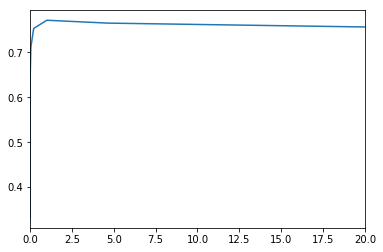

In [33]:
plt.plot(logit_c_values1, logit_mean_cv_scores1)
plt.xlim(0, 20);

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [34]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs=list(logit_c_values2), 
                                            random_state=17, 
                                            cv=skf, 
                                            n_jobs=-1, 
                                            multi_class='multinomial')
logit_grid_searcher2.fit(X_train, y_train)

CPU times: user 4.79 s, sys: 31.7 ms, total: 4.82 s
Wall time: 30.8 s


/home/hq/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [35]:
logit_mean_cv_scores2 = logit_grid_searcher2.scores_[1][0]
logit_mean_cv_scores2

array([0.73729072, 0.76560122, 0.76986301, 0.77077626, 0.76834094,
       0.76803653, 0.76834094, 0.76773212, 0.7674277 , 0.76651446,
       0.7674277 , 0.76681887, 0.76590563, 0.76438356, 0.76407915,
       0.76377473, 0.76347032, 0.76316591, 0.76255708, 0.76316591])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [36]:
print(np.max(logit_mean_cv_scores2))
print(logit_grid_searcher2.C_[6])

0.7707762557077625
1.9157894736842107


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

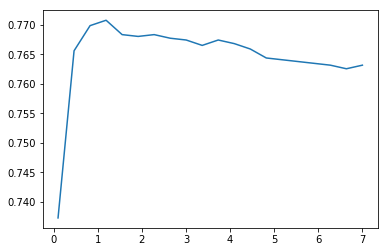

In [37]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [38]:
np.max(logit_mean_cv_scores2)

0.7707762557077625

In [39]:
i = np.argmax(logit_mean_cv_scores2)

In [40]:
print(logit_grid_searcher2.scores_[1][0][i])
print(logit_grid_searcher2.Cs_[i])

0.7707762557077625
1.1894736842105265


**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [41]:
logit_cv_acc = accuracy_score(y_valid, logit_grid_searcher2.predict(X_valid))
logit_cv_acc

0.7790945721735009

In [42]:
ans = np.round([np.max(logit_mean_cv_scores2), logit_cv_acc], 3)
ans = ' '.join(map(str, ans))
print (ans)

write_answer(ans, 'answer3.txt')

0.771 0.779


**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [43]:
from sklearn.svm import LinearSVC

In [56]:
svm = LinearSVC(C=1, random_state=17)

In [52]:
cv_train = cross_val_score(svm, X_train, y_train, cv=skf, n_jobs=-1)

cv_train

array([0.75616438, 0.75480329, 0.75442343])

In [54]:
svm.fit(X_train, y_train)

/home/hq/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=17, tol=0.0001,
          verbose=0)

In [55]:
y_pred = svm.predict(X_valid)
cv_valid = accuracy_score(y_valid, y_pred)
cv_valid

0.7710357904716757

**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [64]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, param_grid=svm_params1, n_jobs=-1, cv=skf)
svm_grid_searcher1.fit(X_train, y_train)

CPU times: user 2.94 s, sys: 87.3 ms, total: 3.03 s
Wall time: 15.9 s


/home/hq/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [65]:
print('Best score is: {} with C: {}'.format(svm_grid_searcher1.best_score_, svm_grid_searcher1.best_params_))

Best score is: 0.700873806136964 with C: {'C': 6666.666700000001}


In [67]:
svm_grid_searcher1.cv_results_ 

{'mean_fit_time': array([0.12079223, 3.25909225, 3.29283762, 3.24357104, 3.32041534,
        3.86634318, 3.79296009, 3.49381304, 3.41364487, 2.15719644]),
 'std_fit_time': array([0.02599748, 0.12885359, 0.24086549, 0.23211344, 0.08129474,
        0.14337307, 0.28949273, 0.27327283, 0.11053417, 0.16481422]),
 'mean_score_time': array([0.0015831 , 0.00155735, 0.00162927, 0.00166869, 0.0015746 ,
        0.00171947, 0.00181953, 0.00159788, 0.00136423, 0.00088112]),
 'std_score_time': array([1.14525823e-04, 4.39673855e-05, 1.29154865e-04, 7.38145872e-05,
        5.97222545e-05, 4.04923384e-05, 2.45310152e-04, 1.21745936e-04,
        1.39838272e-04, 1.11732171e-05]),
 'param_C': masked_array(data=[0.0001, 1111.1112, 2222.2223000000004,
                    3333.3334000000004, 4444.4445000000005,
                    5555.555600000001, 6666.666700000001,
                    7777.777800000001, 8888.8889, 10000.0],
              mask=[False, False, False, False, False, False, False, False,
      

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

In [68]:
from sklearn.model_selection import validation_curve

In [109]:
param_range1 = np.linspace(1e-4, 1e4, 10)

def plot_val_curves(model, X, y, param_range):
    train_scores, test_scores = validation_curve(
    svm, X_train, y_train, param_name="C", param_range=param_range,
    cv=skf, scoring="accuracy", n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.figure(figsize=(15,8))
    plt.title("Validation Curve with SVM")
    plt.xlabel(r"C")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show();

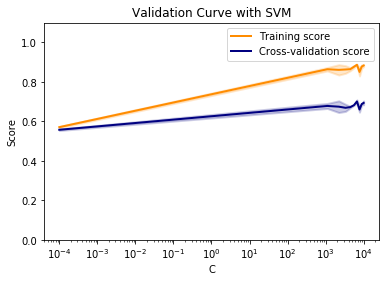

In [77]:
plot_val_curves(svm, X_train, y_train, param_range1)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [80]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, param_grid=svm_params2, cv=skf, n_jobs=-1)
svm_grid_searcher2.fit(X_train, y_train)

CPU times: user 1.26 s, sys: 19.8 ms, total: 1.28 s
Wall time: 23.2 s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [104]:
print ("Best score is: {} with C: {}".format(svm_grid_searcher2.best_score_, svm_grid_searcher2.best_params_))

Best score is: 0.7693558219874009 with C: {'C': 0.20768965517241378}


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

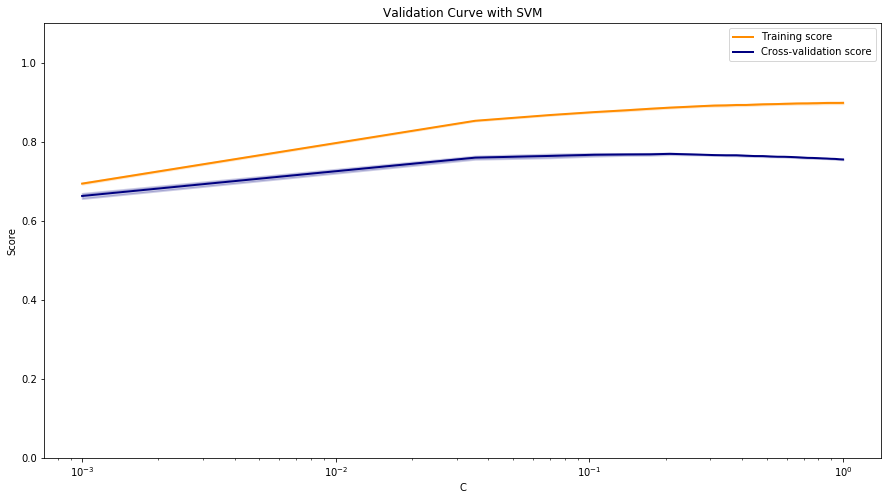

In [110]:
params2 = np.linspace(1e-3, 1, 30)
plot_val_curves(svm, X_train, y_train, params2)

In [ ]:
#plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [108]:
svm = LinearSVC(random_state=17, **svm_grid_searcher2.best_params_)

In [ ]:
svm.fit.

In [ ]:
y_pred = svm.predict(X_valid)
cv_valid = accuracy_score(y_valid, y_pred)
cv_valid

In [111]:
svm_cv_acc = accuracy_score(y_valid, svm_grid_searcher2.predict(X_valid))
svm_cv_acc

0.7755392273050485

In [119]:
svm_grid_searcher2.cv_results_['mean_test_score'][1]

0.7597033123348913

In [ ]:
ans = np.round([np.max(logit_mean_cv_scores2), logit_cv_acc], 3)
ans = ' '.join(map(str, ans))
print (ans)

write_answer(ans, 'answer3.txt')

In [ ]:
svm_grid_searcher2

**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ '''

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [ ]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    
    ''' ВАШ КОД ЗДЕСЬ '''

**Убедитесь, что функция работает.**

In [ ]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [ ]:
!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl 

In [ ]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = ''' ВАШ КОД ЗДЕСЬ '''
        path_to_y_pkl = ''' ВАШ КОД ЗДЕСЬ '''
        print           ''' ВАШ КОД ЗДЕСЬ '''

**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ '''

**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [ ]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    path_to_X_pkl = ''' ВАШ КОД ЗДЕСЬ '''
    path_to_y_pkl = ''' ВАШ КОД ЗДЕСЬ '''
    print           ''' ВАШ КОД ЗДЕСЬ '''

**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ '''

## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [ ]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [ ]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [ ]:
%%time
logit_cv_150users = LogisticRegressionCV ''' ВАШ КОД ЗДЕСЬ '''
logit_cv_150users.fit(X_train_150, y_train_150)

**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [ ]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    print('User {}, CV score: {}'.format ''' ВАШ КОД ЗДЕСЬ '''

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [ ]:
class_distr = np.bincount(y_train_150.astype('int'))

for user_id in np.unique(y_train_150):
    ''' ВАШ КОД ЗДЕСЬ '''

In [ ]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()

**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ '''

**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [ ]:
y_binary_128 = ''' ВАШ КОД ЗДЕСЬ '''

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [ ]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve ''' ВАШ КОД ЗДЕСЬ '''

In [ ]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

## Пути улучшения
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей


На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.